In [1]:
from collections import defaultdict
import dotenv
import json
import pandas as pd
import nltk
import numpy as np

# import util
from third_party.nltk_book import chunkers

from src.features import build_features
from src.models import train_nltk


In [2]:
config = dotenv.dotenv_values(dotenv_path=dotenv.find_dotenv())

In [3]:
# data_config = util.get_data_config()

In [4]:
nltk.download(['punkt', 'averaged_perceptron_tagger'])
# Optional
nltk.download(['brown', 'conll2000',])

[nltk_data] Downloading package punkt to
[nltk_data]     /home/dimosthenis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dimosthenis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     /home/dimosthenis/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /home/dimosthenis/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

# Load Data

In [5]:
# summaries_df = pd.read_parquet(config['summaries_file_name'])
summaries_df = pd.read_parquet(config['preprocessed_summaries_file_name'])
summaries_df.shape

(51, 3)

In [6]:
summaries_df.head()

,nct_id,brief_summary,brief_summary_preprocessed
0,NCT00037648,The purpose of this study is to determine the ...,"[the, purpose, of, this, study, is, to, determ..."
1,NCT00048542,"This is a multicenter, Phase 3 randomized, pla...","[this, is, a, multicenter, ,, phase, 3, random..."
2,NCT00071487,The purpose of this study is to evaluate the s...,"[the, purpose, of, this, study, is, to, evalua..."
3,NCT00071812,The purpose of this study is to evaluate the s...,"[the, purpose, of, this, study, is, to, evalua..."
4,NCT00072839,The purpose of the study is to determine wheth...,"[the, purpose, of, the, study, is, to, determi..."


In [7]:
synonyms_df = pd.read_parquet(config['processed_synonyms_file_name'])

synonyms_df.head()

,preferred_name,synonyms
id,,
4.0,levobupivacaine,"[chirocain, levobupivacaine, levobupivacaine h..."
5.0,(S)-nicardipine,"[(-)-nicardipine, (s)-nicardipine]"
6.0,(S)-nitrendipine,"[(-)-nitrendipine, (s)-nitrendipine]"
13.0,levdobutamine,"[levdobutamine, levdobutamine lactobionate, ly..."
21.0,aminopterin,"[4-aminofolic acid, aminofolic acid, 4-, amino..."


In [8]:
synonyms_gt_df = pd.read_parquet(config['synonyms_ground_truth_file_name'])
synonyms_gt_df['synonym_gt_trees'] =  synonyms_gt_df['synonym_gt_trees'].map(build_features.parse_gt_tree)
synonyms_gt_df.head()

,synonym,synonym_tag_gt,synonym_gt_trees
0,chirocain,"[[chirocain, C1E]]","[[(chirocain, C1E)]]"
1,levobupivacaine,"[[levobupivacaine, C1E]]","[[(levobupivacaine, C1E)]]"
2,levobupivacaine hcl,"[[levobupivacaine, C2S], [hcl, C2E]]","[[(levobupivacaine, C2S), (hcl, C2E)]]"
3,levobupivacaine hydrochloride,"[[levobupivacaine, C2S], [hydrochloride, C2E]]","[[(levobupivacaine, C2S), (hydrochloride, C2E)]]"
4,(-)-nicardipine,"[[(, C4S], [-, C4S], [), C4S], [-nicardipine, ...","[[[('-', 'C4S')], (, C4S), (-nicardipine, C4E)]]"


In [9]:
synonyms_gt_df.columns

Index(['synonym', 'synonym_tag_gt', 'synonym_gt_trees'], dtype='object')

In [10]:
with open(config['ground_truth_raw_file_name'], 'r') as fin:
    ground_truth = json.loads(fin.read())
    
with open(config['ground_truth_cleaned_file_name'], 'r') as fin:
    ground_truth_cleaned = json.loads(fin.read())

with open(config['tagged_synonyms_file_name'], 'r') as fin:
    dataset_by_ngram = json.load(fin)

# NgramTagger that uses N-1 tokens (instead of N-1 tags). 

We train a series of `NgramTagger`s, one for each ngram size in the ground truth, The tagger with the highest `N` is applied first and if it cannot tag a temrm it uses the tager with the next lowest `N`. 

In [11]:
taggers = [nltk.DefaultTagger('O')]
keys = sorted([int(key) for key in dataset_by_ngram.keys()])
for n in keys:
    print(n)
    train = dataset_by_ngram[str(n)]
    ngram_tagger = train_nltk.WordNgramTagger(n=int(n), train=train, backoff=taggers[-1])
    taggers.append(ngram_tagger)

tagger = taggers[-1]

1
2
3
4
5
6
7
8
9
14
19


In [12]:
tagger_accuracy = tagger.accuracy(synonyms_gt_df['synonym_tag_gt'])
print(f'Tagger Accuracy: {tagger_accuracy}')

Tagger Accuracy: [1.         0.84607568]


## Try a RegexpParser as a Chunker.

In [13]:
grammar = '''NP: {<C1E>}'''
keys = sorted([int(key) for key in dataset_by_ngram.keys()])
for num_tokens in keys:
    if num_tokens == 1:
        continue
    grammar += '\n{<C\dS>{' + str(num_tokens-1) + '}<C' + str(num_tokens) + 'E>}'
print(grammar)
regexp_parser = nltk.RegexpParser(grammar)

NP: {<C1E>}
{<C\dS>{1}<C2E>}
{<C\dS>{2}<C3E>}
{<C\dS>{3}<C4E>}
{<C\dS>{4}<C5E>}
{<C\dS>{5}<C6E>}
{<C\dS>{6}<C7E>}
{<C\dS>{7}<C8E>}
{<C\dS>{8}<C9E>}
{<C\dS>{13}<C14E>}
{<C\dS>{18}<C19E>}


In [14]:
df = synonyms_gt_df.copy()
df['tree'] = df['synonym'].map(lambda syn: train_nltk.parse(syn, chunker=regexp_parser, tagger=tagger))
df['extracted'] = df['tree'].map(train_nltk.extract_chunked_terms)

# all_terms = [
#     synonym
#     for synonyms in synonyms_df['synonyms']
#     for synonym in synonyms
# ]

# all_trees = [
#     train_nltk.parse(term, chunker=regexp_parser, tagger=tagger)
#     for term in all_terms
# ]
# extracted = [
#     train_nltk.extract_chunked_terms(tree) for tree in all_trees
# ]

# df = pd.DataFrame({
#     'term': all_terms,
#     'tree': all_trees,
#     'extracted': extracted
# })

In [15]:
# synonym_tag_gt = [
#     build_features.get_synonym_tags(build_features.preprocess_text(term))
#     for term in all_terms
# ]

# all_tags = [
#     tagger.tag(build_features.preprocess_text(term))
#     for term in all_terms
# ]
# tagger.accuracy(all_tags), tagger.accuracy(synonym_tag_gt)
# (1.0, 0.0, 0.8460756769681391)

In [16]:
print(regexp_parser.accuracy(synonyms_gt_df['synonym_gt_trees']))

ChunkParse score:
    IOB Accuracy: 100.0%%
    Precision:    100.0%%
    Recall:        97.9%%
    F-Measure:     99.0%%


```print(regexp_parser.accuracy(synonym_gt_trees))```

ChunkParse score:
 - IOB Accuracy:  99.9%%
 - Precision:    100.0%%
 - Recall:       100.0%%
 - F-Measure:    100.0%%

In [17]:
df['extracted_count'] = df['extracted'].map(len)
df['extracted_count'].value_counts()

extracted_count
1    20634
0     2593
Name: count, dtype: int64

In [18]:
df.head(10)

,synonym,synonym_tag_gt,synonym_gt_trees,tree,extracted,extracted_count
0,chirocain,"[[chirocain, C1E]]","[[(chirocain, C1E)]]","[[(chirocain, C1E)]]",[chirocain],1
1,levobupivacaine,"[[levobupivacaine, C1E]]","[[(levobupivacaine, C1E)]]","[(levobupivacaine, C2S)]",[],0
2,levobupivacaine hcl,"[[levobupivacaine, C2S], [hcl, C2E]]","[[(levobupivacaine, C2S), (hcl, C2E)]]","[[(levobupivacaine, C2S), (hcl, C2E)]]",[levobupivacainehcl],1
3,levobupivacaine hydrochloride,"[[levobupivacaine, C2S], [hydrochloride, C2E]]","[[(levobupivacaine, C2S), (hydrochloride, C2E)]]","[[(levobupivacaine, C2S), (hydrochloride, C2E)]]",[levobupivacainehydrochloride],1
4,(-)-nicardipine,"[[(, C4S], [-, C4S], [), C4S], [-nicardipine, ...","[[[('-', 'C4S')], (, C4S), (-nicardipine, C4E)]]","[[((, C9S), (-, C9S), (), C9S), (-nicardipine,...",[(-)-nicardipine],1
5,(s)-nicardipine,"[[(, C4S], [s, C4S], [), C4S], [-nicardipine, ...","[[[('s', 'C4S')], (, C4S), (-nicardipine, C4E)]]","[[((, C9S), (s, C8S), (), C8S), (-nicardipine,...",[(s)-nicardipine],1
6,(-)-nitrendipine,"[[(, C4S], [-, C4S], [), C4S], [-nitrendipine,...","[[[('-', 'C4S')], (, C4S), (-nitrendipine, C4E)]]","[[((, C9S), (-, C9S), (), C9S), (-nitrendipine...",[(-)-nitrendipine],1
7,(s)-nitrendipine,"[[(, C4S], [s, C4S], [), C4S], [-nitrendipine,...","[[[('s', 'C4S')], (, C4S), (-nitrendipine, C4E)]]","[[((, C9S), (s, C8S), (), C8S), (-nitrendipine...",[(s)-nitrendipine],1
8,levdobutamine,"[[levdobutamine, C1E]]","[[(levdobutamine, C1E)]]","[(levdobutamine, C2S)]",[],0
9,levdobutamine lactobionate,"[[levdobutamine, C2S], [lactobionate, C2E]]","[[(levdobutamine, C2S), (lactobionate, C2E)]]","[[(levdobutamine, C2S), (lactobionate, C2E)]]",[levdobutaminelactobionate],1


In [62]:
df['extracted'].map(len).value_counts()

extracted
1    20634
0     2593
Name: count, dtype: int64

In [19]:
def is_correct(term: str, extracted: list[str]) -> bool:
    if not extracted:
        return False
    return term.replace(' ', '') == extracted[0]
df['correct'] = df.apply(lambda row: is_correct(row['synonym'], row['extracted']), axis=1)
print(f'Accuracy: {df.correct.mean():.2%}')

Accuracy: 88.84%


In [20]:
df['synonym_token_count'] = df['synonym'].map(lambda syn: len(nltk.word_tokenize(syn)))

In [21]:
df[df['extracted_count']==0].synonym_token_count.value_counts()

synonym_token_count
1     2202
2      362
3       23
4        4
14       1
19       1
Name: count, dtype: int64

In [22]:
_df = df[df['extracted_count']==0].copy()
_df

,synonym,synonym_tag_gt,synonym_gt_trees,tree,extracted,extracted_count,correct,synonym_token_count
1,levobupivacaine,"[[levobupivacaine, C1E]]","[[(levobupivacaine, C1E)]]","[(levobupivacaine, C2S)]",[],0,False,1
8,levdobutamine,"[[levdobutamine, C1E]]","[[(levdobutamine, C1E)]]","[(levdobutamine, C2S)]",[],0,False,1
13,aminopterin,"[[aminopterin, C1E]]","[[(aminopterin, C1E)]]","[(aminopterin, C2S)]",[],0,False,1
44,5-fluorouracil,"[[5-fluorouracil, C1E]]","[[(5-fluorouracil, C1E)]]","[(5-fluorouracil, C2S)]",[],0,False,1
73,abacavir,"[[abacavir, C1E]]","[[(abacavir, C1E)]]","[(abacavir, C2S)]",[],0,False,1
...,...,...,...,...,...,...,...,...
23155,ensitrelvir,"[[ensitrelvir, C1E]]","[[(ensitrelvir, C1E)]]","[(ensitrelvir, C3S)]",[],0,False,1
23162,ritlecitinib,"[[ritlecitinib, C1E]]","[[(ritlecitinib, C1E)]]","[(ritlecitinib, C2S)]",[],0,False,1
23175,durlobactam,"[[durlobactam, C1E]]","[[(durlobactam, C1E)]]","[(durlobactam, C2S)]",[],0,False,1
23184,tofersen,"[[tofersen, C1E]]","[[(tofersen, C1E)]]","[(tofersen, C2S)]",[],0,False,1


In [23]:
_df[_df['synonym_token_count']==2].head()

,synonym,synonym_tag_gt,synonym_gt_trees,tree,extracted,extracted_count,correct,synonym_token_count
131,acefylline piperazine,"[[acefylline, C2S], [piperazine, C2E]]","[[(acefylline, C2S), (piperazine, C2E)]]","[(acefylline, C3S), (piperazine, C3S)]",[],0,False,2
251,acetopromazine maleate,"[[acetopromazine, C2S], [maleate, C2E]]","[[(acetopromazine, C2S), (maleate, C2E)]]","[(acetopromazine, C3S), (maleate, C3S)]",[],0,False,2
321,adenosine triphosphate,"[[adenosine, C2S], [triphosphate, C2E]]","[[(adenosine, C2S), (triphosphate, C2E)]]","[(adenosine, C4S), (triphosphate, C4S)]",[],0,False,2
423,alendronate sodium,"[[alendronate, C2S], [sodium, C2E]]","[[(alendronate, C2S), (sodium, C2E)]]","[(alendronate, C4S), (sodium, C3S)]",[],0,False,2
548,alverine citrate,"[[alverine, C2S], [citrate, C2E]]","[[(alverine, C2S), (citrate, C2E)]]","[(alverine, C3S), (citrate, C3S)]",[],0,False,2


# Create Chunker training data and ground truth

## Chunker training data

Chunker training data is created by using the synonym lists to create tagged trees and interjecting random words which are labeled 'O'.


In [24]:
filler_words = build_features.preprocess_text(
    'The purpose of this study is to evaluate the safety and efficacy of 3 different doses of '
    'administered in addition to standard therapy, in patients with active SLE disease.'
# ).lower().split()
)

train_tree_synonyms = []
for synonyms in synonyms_df['synonyms']:
    trees = []
    for synonym in synonyms:
        tokens = nltk.word_tokenize(synonym)
        synonym_tags = build_features.get_synonym_tags(tokens)
            
        tree = build_features.create_chunk_tree(synonym_tags)
        trees.append(tree)
        
        trees.extend(build_features.get_random_filler_trees(filler_words))
    
    
    train_tree_synonyms.append(nltk.Tree('S', trees))
        

In [25]:
assert max([t.height() for t in train_tree_synonyms]) == 3

In [26]:
# Check that tree height is at most 3.
# for index, tree in enumerate(train_tree_synonyms):
#     if tree.height()>3:
#         print('found')
#         break

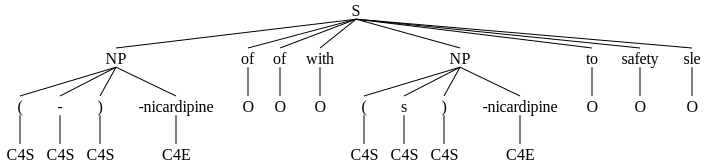

In [27]:
train_tree_synonyms[1]

## Chunker ground truth data

In [28]:
tagger = taggers[-1]
test_trees_gt = []
for _, row in summaries_df.iterrows():
    nct_id = row['nct_id']
    keywords = [kw.lower() for kw in ground_truth[nct_id]]
    brief_summary_raw = row['brief_summary'].lower()
    
    tree = build_features.get_gt_tree(brief_summary_raw, keywords)
    assert ''.join(build_features.split_summary_by_keywords(brief_summary_raw, keywords)) == brief_summary_raw
    test_trees_gt.append(tree)

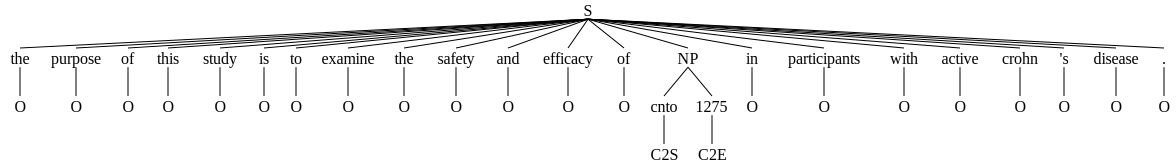

In [29]:
test_trees_gt[45]

# Classifier based chunker

In [31]:
chunker = chunkers.ConsecutiveNPChunker(
    train_sents=train_tree_synonyms,
    feature_generator_fn=build_features.get_feature_generator('npchunk_features_bigram_pos')
)

In [66]:
# Training set evaluation metric for the Chunker.
print('chunkers.ConsecutiveNPChunker on train_tree_synonyms:', chunker.accuracy(train_tree_synonyms))

chunkers.ConsecutiveNPChunker on train_tree_synonyms: ChunkParse score:
    IOB Accuracy: 100.0%%
    Precision:    100.0%%
    Recall:       100.0%%
    F-Measure:    100.0%%


In [67]:
print('regexp_parser on train_tree_synonyms:', regexp_parser.accuracy(train_tree_synonyms))

regexp_parser on train_tree_synonyms: ChunkParse score:
    IOB Accuracy: 100.0%%
    Precision:    100.0%%
    Recall:       100.0%%
    F-Measure:    100.0%%


In [68]:
print('chunkers.ConsecutiveNPChunker on test_trees_gt:', chunker.accuracy(test_trees_gt))

chunkers.ConsecutiveNPChunker on test_trees_gt: ChunkParse score:
    IOB Accuracy: 100.0%%
    Precision:    100.0%%
    Recall:       100.0%%
    F-Measure:    100.0%%


In [69]:
print('chunkers.ConsecutiveNPChunker on synonym_gt_trees', chunker.accuracy(synonyms_gt_df['synonym_gt_trees']))

chunkers.ConsecutiveNPChunker on synonym_gt_trees ChunkParse score:
    IOB Accuracy: 100.0%%
    Precision:     97.9%%
    Recall:        97.9%%
    F-Measure:     97.9%%


In [70]:
chunker_eval_df = synonyms_gt_df.copy()
chunker_eval_df['tree'] = chunker_eval_df['synonym'].map(
    lambda syn: train_nltk.parse(syn, chunker=chunker, tagger=tagger))
chunker_eval_df['extracted'] = chunker_eval_df['tree'].map(train_nltk.extract_chunked_terms)
chunker_eval_df['extracted_count'] = chunker_eval_df['extracted'].map(len)
chunker_eval_df['synonym_token_count'] = chunker_eval_df['synonym'].map(lambda syn: len(nltk.word_tokenize(syn)))

In [71]:
chunker_eval_df['correct'] = chunker_eval_df.apply(lambda row: is_correct(row['synonym'], row['extracted']), axis=1)
print(f'chunkers.ConsecutiveNPChunker Accuracy on synonym_gt_trees: {df.correct.mean():.2%}')

chunkers.ConsecutiveNPChunker Accuracy on synonym_gt_trees: 88.84%


In [60]:
chunker_eval_df['extracted_count'].value_counts()

extracted_count
1    23227
Name: count, dtype: int64

## Test set evaluation metric for the Chunker.

In [34]:
tagger = taggers[-1]
# test_trees = summaries_df['brief_summary'].map(lambda text: chunker.parse(tagger.tag(text)))
test_trees = summaries_df['brief_summary'].map(lambda text: train_nltk.parse(text, chunker=chunker, tagger=tagger))

In [35]:
max([t.height() for t in train_tree_synonyms])

3

In [36]:
# Note: 100% is too good, the dataset is rather small.
print(chunker.accuracy(test_trees))

ChunkParse score:
    IOB Accuracy: 100.0%%
    Precision:    100.0%%
    Recall:       100.0%%
    F-Measure:    100.0%%


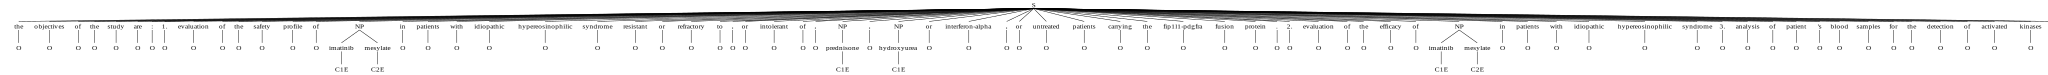

In [37]:
test_trees[26]

## Extract terms and map to preferred names

In [38]:
synonym_maps = build_features.get_synonym_maps(synonyms_df)
preferred_name_by_term = synonym_maps['preferred_name_by_term']

In [39]:
def extract_preferred_names_from_tree(tree, chunk_tag: str = 'NP') -> list[str]:
    terms = train_nltk.extract_chunked_terms(tree=tree, chunk_tag=chunk_tag)
    term_prefered_names = []
    for term_raw in terms:
        term = term_raw.lower()
        # print(term, term_raw)
        if term not in preferred_name_by_term:
            continue
        term_prefered_names.append(preferred_name_by_term[term])
    return list(set(term_prefered_names))    
    

In [40]:
extracted_terms = []
for tree in test_trees:
    extracted_terms.append(extract_preferred_names_from_tree(tree))
test_df = pd.DataFrame({
    'nct_id': summaries_df['nct_id'],
    'extracted_terms': extracted_terms
})

## Evaluate

In [41]:
test_df['gt_cleaned'] = test_df.nct_id.map(lambda x: ground_truth_cleaned[x])

In [42]:
test_df['match_count'] = test_df.apply(lambda row: len(set(row['extracted_terms']).intersection(set(row['gt_cleaned']))), axis=1)

In [43]:
test_df.head()

,nct_id,extracted_terms,gt_cleaned,match_count
0,NCT00037648,[anakinra],[anakinra],1
1,NCT00048542,"[methotrexate, adalimumab]","[adalimumab, methotrexate]",2
2,NCT00071487,[belimumab],[belimumab],1
3,NCT00071812,[belimumab],[belimumab],1
4,NCT00072839,[teduglutide],[teduglutide],1


In [44]:
test_df['extracted_terms_count'] = test_df['extracted_terms'].map(len)
test_df['gt_cleaned_count'] = test_df['gt_cleaned'].map(len)

In [45]:
true_positive_count = test_df['match_count'].sum()
precision = true_positive_count / test_df['extracted_terms_count'].sum()
recall = true_positive_count / test_df['gt_cleaned_count'].sum()
print(f'Precision: {precision: .2%}')
print(f'Recall: {recall: .2%}')


Precision:  100.00%
Recall:  98.25%


In [46]:
misses_df = test_df[(test_df['match_count'] != test_df['extracted_terms_count']) | (test_df['match_count'] != test_df['gt_cleaned_count'])]
misses_df

,nct_id,extracted_terms,gt_cleaned,match_count,extracted_terms_count,gt_cleaned_count
45,NCT00265122,[],[ustekinumab],0,0,1


### Check specific case(s)

In [47]:
nct_id = 'NCT00265122'

In [48]:
_sum = summaries_df[summaries_df['nct_id']==nct_id].brief_summary_preprocessed.iloc[0]
print(_sum)

['the' 'purpose' 'of' 'this' 'study' 'is' 'to' 'examine' 'the' 'safety'
 'and' 'efficacy' 'of' 'cnto' '1275' 'in' 'participants' 'with' 'active'
 'crohn' "'s" 'disease' '.']


In [49]:
_sum_raw = summaries_df[summaries_df['nct_id']==nct_id].brief_summary.iloc[0]
print(_sum_raw)

The purpose of this study is to examine the safety and efficacy of CNTO 1275 in participants with active Crohn's Disease.


In [50]:
index = summaries_df[summaries_df['nct_id']=='NCT00265122'].index[0]
index

45

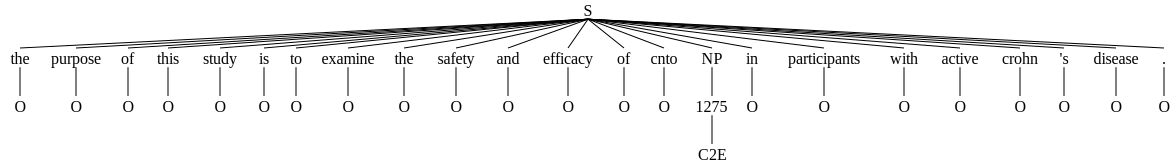

In [51]:
# This is a tagger issue, 'cnto' is tagged as other, it should have been tagged as 'C2E'
test_trees[index]

In [52]:
raw_synonym_maps = build_features.get_synonym_maps(synonyms_df, clean_up_terms=False)
raw_terms_by_preferred_name = raw_synonym_maps['terms_by_preferred_name']

In [53]:
_pref_name = 'ustekinumab'
for term in raw_terms_by_preferred_name[_pref_name]:
    if term in _sum_raw:
        print(term)
raw_terms_by_preferred_name[_pref_name]

array(['cnto 1275', 'cnto-1275', 'stelara', 'ustekinumab'], dtype=object)

# Save

In [54]:
test_df.to_parquet(config['extraction_nltk_file_name'], index=False) 